In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import re

from utils import *
from matplotlib import pyplot as plt
from pymongo import MongoClient

### Parâmetros do matplot e Seaborn

In [2]:
%matplotlib inline
pd.options.mode.chained_assignment = None 
plt.rcParams['figure.figsize'] = [10, 5]
sns.set(rc={'figure.figsize':(15,10)})

### Recuperação de Datasets do MongoDB

In [3]:
df_meteorologia_2010_2019 = mongo_to_dataframe("meteorologia_2010_2019")

In [4]:
df_acidentes_fatais_2008_2017 = mongo_to_dataframe("acidentes_fatais_2008_2017")

In [84]:
df_acidentes_rodovias_2010_2019 = mongo_to_dataframe("acidentes_rodovias_2010_2019")

In [ ]:
df_infracoes_prf_2010_2018 = mongo_to_dataframe("infracoes_prf_2010_2018")

In [ ]:
df_infracoes_der_2018_2019 = mongo_to_dataframe("infracoes_der_2018_2019")

## Análise dos acidentes fatais em relação com condições climáticas

### Observações
- Os meses mais chuvosos vão de novembro até março, enquanto a época de estiagem compreende o período de maio a setembro. Abril e outubro são meses que estão entre as estações de secas e chuvas.
- Os índices de precipitação não são constantes no decorrer dos anos a depender do mês.
- As condições meteorológicas nas quais ocorreram mais acidentes nas rodovias foram de céu claro, chuvosa, nublada e ensolarada.
- Existe uma ocorrência de um acidente na BR-060 de um acidente cuja condição meteorológica era de neve.
- A correlação de Pearson, tanto dos acidentes nas rodovias quanto dos dados do DER deram por volta de -0,3. Esse resultado mostra que é uma correlação negativa fraca.
- Com isso, meses com índices de precipitação mais altos não necessariamente são aqueles com mais acidentes.

In [6]:
dict_meses = {1: 'Janeiro',
              2: 'Fevereiro',
              3: 'Março',
              4: 'Abril',
              5: 'Maio',
              6: 'Junho',
              7: 'Julho',
              8: 'Agosto',
              9: 'Setembro',
              10: 'Outubro',
              11: 'Novembro',
              12: 'Dezembro'}

Text(0, 0.5, 'Precipitação (mm)')

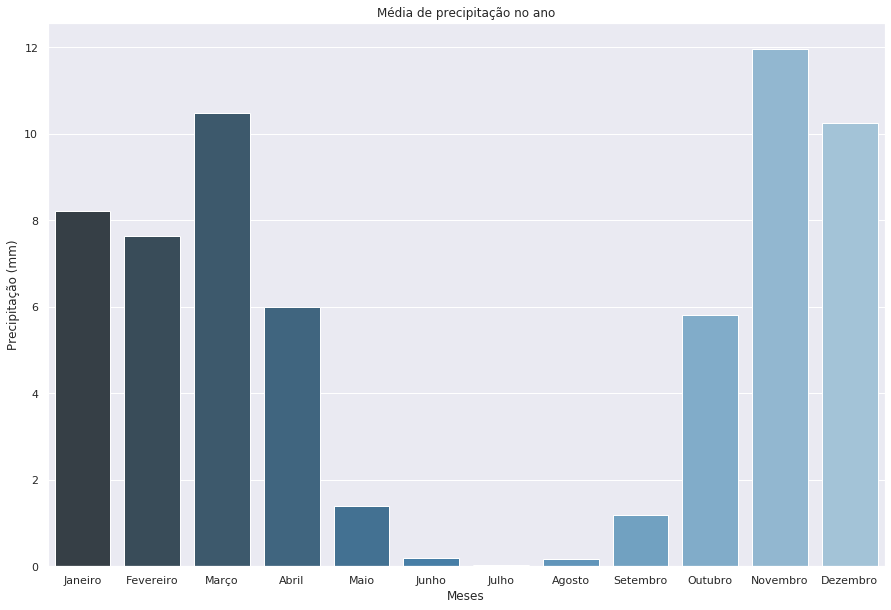

In [7]:
df_meteorologia_2010_2019['Mes'] = df_meteorologia_2010_2019['Data'].dt.month
media_precipitacao_meses = df_meteorologia_2010_2019.groupby('Mes').mean().reset_index()
media_precipitacao_meses = media_precipitacao_meses[['Mes', 'Precipitacao']]

media_precipitacao_meses['Mes'] = media_precipitacao_meses['Mes'].replace(dict_meses)
sns.barplot(x = media_precipitacao_meses['Mes'], y = media_precipitacao_meses['Precipitacao'], data = media_precipitacao_meses, palette = "Blues_d")
plt.title("Média de precipitação no ano")
plt.xlabel("Meses")
plt.ylabel("Precipitação (mm)")

In [8]:
historico_precipitacao_meses = df_meteorologia_2010_2019
historico_precipitacao_meses['Ano'] = historico_precipitacao_meses['Data'].dt.year
historico_precipitacao_meses['Mes Ano'] = historico_precipitacao_meses['Mes'] * 10000 + historico_precipitacao_meses['Ano']
historico_precipitacao_meses = historico_precipitacao_meses.groupby('Mes Ano').mean().reset_index()
historico_precipitacao_meses['Mes'] = historico_precipitacao_meses['Mes'].replace(dict_meses)
historico_precipitacao_meses.head()

,Mes Ano,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao Piche,Temp Comp Media,Umidade Relativa Media,Velocidade do Vento Media,Mes,Ano
0,12010,8.770968,28.032258,18.461290,6.848387,4.651613,22.503871,76.000000,2.548387,Janeiro,2010
1,12011,4.612903,27.451613,18.451613,6.545161,3.883871,22.007097,79.701613,3.010753,Janeiro,2011
2,12012,10.238710,25.648387,17.345161,3.703226,2.861290,20.649677,83.548387,2.311828,Janeiro,2012
3,12013,18.996774,26.522581,18.277419,4.245161,3.519355,21.582581,81.629032,2.295699,Janeiro,2013
4,12014,5.719355,28.041935,17.870968,8.432258,5.309677,22.288387,72.491935,2.335818,Janeiro,2014


In [9]:
def plot_precipitacao_meses(meses):
    plot = sns.FacetGrid(meses, col='Mes')
    plot.map(sns.barplot, 'Ano', 'Precipitacao')
    plot.set_xticklabels(rotation=90)

/home/hugo/anaconda3/envs/tcc/lib/python3.7/site-packages/seaborn/axisgrid.py:715: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


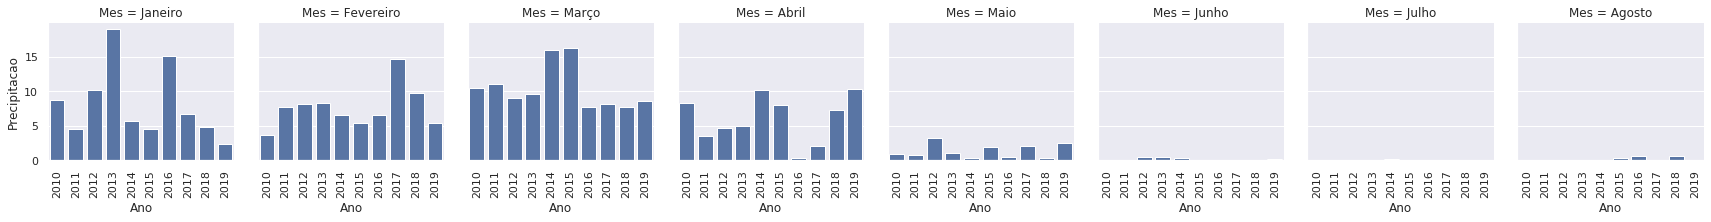

In [10]:
jan_ago = historico_precipitacao_meses.loc[historico_precipitacao_meses['Mes Ano'] <= 82019]
plot_precipitacao_meses(jan_ago)

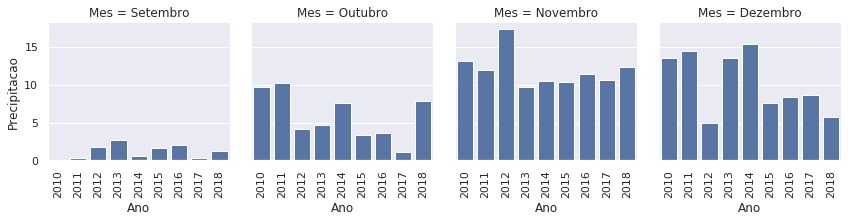

In [11]:
set_dez = historico_precipitacao_meses.loc[historico_precipitacao_meses['Mes Ano'] > 82019]
plot_precipitacao_meses(set_dez)

Text(0, 0.5, 'Média de acidentes')

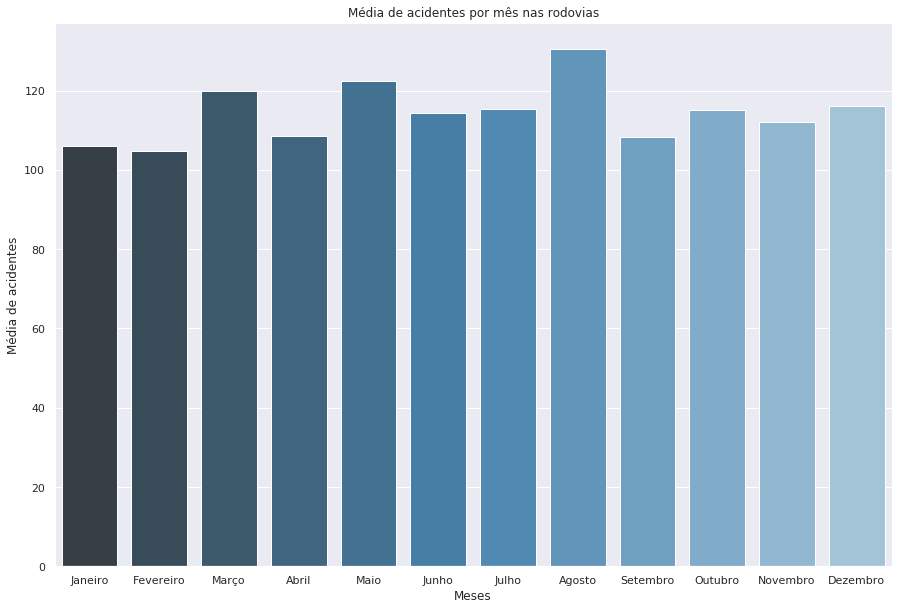

In [12]:
df_acidentes_rodovias_2010_2019['Mes'] = df_acidentes_rodovias_2010_2019['data_inversa'].dt.month
media_acidentes_rodovias_meses = df_acidentes_rodovias_2010_2019.groupby('Mes').count().reset_index()
media_acidentes_rodovias_meses[media_acidentes_rodovias_meses.Mes <= 7] = media_acidentes_rodovias_meses / 9
media_acidentes_rodovias_meses[media_acidentes_rodovias_meses.Mes > 7] = media_acidentes_rodovias_meses / 8
media_acidentes_rodovias_meses['Mes'] = media_acidentes_rodovias_meses.index + 1
media_acidentes_rodovias_meses = media_acidentes_rodovias_meses[['Mes', 'causa_acidente']]

media_acidentes_rodovias_meses['Mes'] = media_acidentes_rodovias_meses['Mes'].replace(dict_meses)
sns.barplot(x = media_acidentes_rodovias_meses['Mes'], y = media_acidentes_rodovias_meses['causa_acidente'], data = media_acidentes_rodovias_meses, palette = "Blues_d")
plt.title("Média de acidentes por mês nas rodovias")
plt.xlabel("Meses")
plt.ylabel("Média de acidentes")

In [68]:
df_acidentes_rodovias_2010_2019['condicao_metereologica'].unique().tolist()

['Chuva',
 'Sol',
 'Ceu Claro',
 'Nublado',
 'Ignorada',
 'Nevoeiro/neblina',
 'Vento',
 'Céu Claro           ',
 'Nublado             ',
 'Sol                 ',
 'Chuva               ',
 'Ignorado            ',
 'Garoa/Chuvisco      ',
 'Nevoeiro/Neblina    ',
 'Vento               ',
 'Céu Claro',
 'Garoa/Chuvisco',
 'Ignorado',
 'Nevoeiro/Neblina',
 'Neve',
 'Granizo']

In [70]:
# Substitui string para padronizar determinada coluna do dataframe.
def padroniza_coluna_dataset(dataframe, coluna, nao_padrao, padrao):
    dataframe[coluna] = dataframe[coluna].str.replace(nao_padrao, padrao)

In [69]:
# Os dados de condicoes meteorologicas possuem labels iguais, mas formatadas de maneira diferente.
df_acidentes_rodovias_2010_2019['condicao_metereologica'] = df_acidentes_rodovias_2010_2019['condicao_metereologica'].str.lower()
padroniza_condicao_metereologica(df_acidentes_rodovias_2010_2019, 'condicao_metereologica', 'é', 'e')
padroniza_condicao_metereologica(df_acidentes_rodovias_2010_2019, 'condicao_metereologica', ' ', '')
padroniza_condicao_metereologica(df_acidentes_rodovias_2010_2019, 'condicao_metereologica', 'uc', 'u c')
padroniza_condicao_metereologica(df_acidentes_rodovias_2010_2019, 'condicao_metereologica', 'ignorado', 'ignorada')

df_acidentes_rodovias_2010_2019['condicao_metereologica'].unique().tolist()

['chuva',
 'sol',
 'ceu claro',
 'nublado',
 'ignorada',
 'nevoeiro/neblina',
 'vento',
 'garoa/chuvisco',
 'neve',
 'granizo']

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

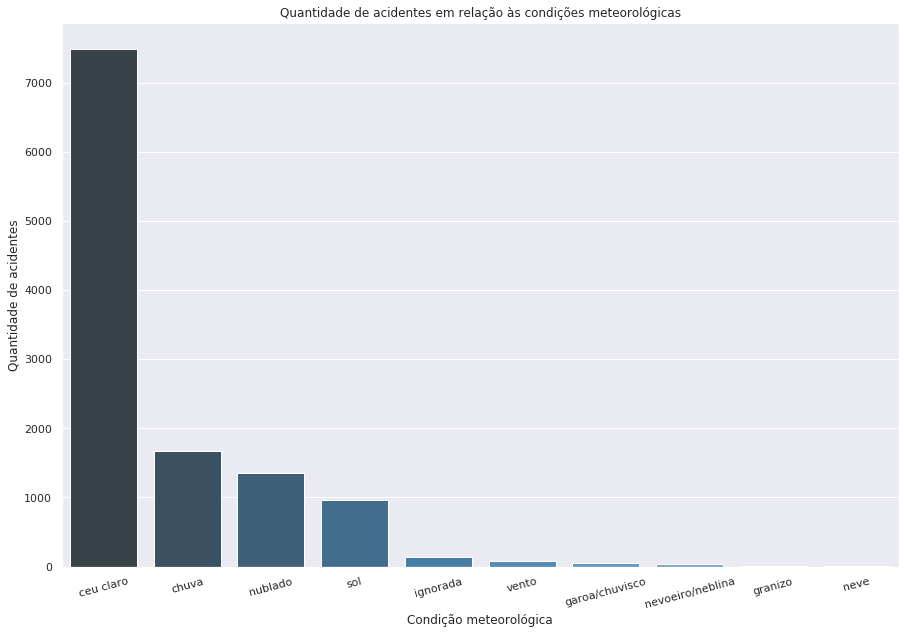

In [58]:
condicoes_metereologicas = df_acidentes_rodovias_2010_2019.groupby('condicao_metereologica').count().reset_index().sort_values('causa_acidente', ascending=False)

sns.barplot(x = condicoes_metereologicas['condicao_metereologica'],
            y = condicoes_metereologicas['causa_acidente'],
            data = condicoes_metereologicas,
            palette = "Blues_d")
plt.title("Quantidade de acidentes em relação às condições meteorológicas")
plt.xlabel("Condição meteorológica")
plt.ylabel("Quantidade de acidentes")
plt.xticks(rotation=15)

In [60]:
# pd.set_option('display.max_columns', 500)
condicoes_meteorologicas = ['ceu claro','chuva', 'nublado', 'sol']
acidentes_sol_chuva = df_acidentes_rodovias_2010_2019.loc[df_acidentes_rodovias_2010_2019['condicao_metereologica'].isin(condicoes_meteorologicas)]
acidentes_sol_chuva = acidentes_sol_chuva.groupby()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11465 entries, 0 to 11780
Data columns (total 25 columns):
data_inversa              11465 non-null datetime64[ns]
dia_semana                11465 non-null object
horario                   11465 non-null object
uf                        11465 non-null object
br                        11460 non-null float64
km                        11460 non-null object
causa_acidente            11465 non-null object
tipo_acidente             11465 non-null object
classificacao_acidente    11465 non-null object
fase_dia                  11465 non-null object
sentido_via               11465 non-null object
condicao_metereologica    11465 non-null object
tipo_pista                11465 non-null object
tracado_via               11465 non-null object
uso_solo                  11465 non-null object
ano                       11465 non-null int64
pessoas                   11465 non-null int64
mortos                    11465 non-null int64
feridos_leves        

In [26]:
df_acidentes_rodovias_2010_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11781 entries, 0 to 11780
Data columns (total 25 columns):
data_inversa              11781 non-null datetime64[ns]
dia_semana                11781 non-null object
horario                   11781 non-null object
uf                        11781 non-null object
br                        11776 non-null float64
km                        11776 non-null object
causa_acidente            11781 non-null object
tipo_acidente             11781 non-null object
classificacao_acidente    11781 non-null object
fase_dia                  11781 non-null object
sentido_via               11781 non-null object
condicao_metereologica    11781 non-null object
tipo_pista                11781 non-null object
tracado_via               11781 non-null object
uso_solo                  11781 non-null object
ano                       11781 non-null int64
pessoas                   11781 non-null int64
mortos                    11781 non-null int64
feridos_leves        

In [83]:
padroniza_coluna_dataset(df_acidentes_rodovias_2010_2019, 'tipo_acidente', '  ', '-')
padroniza_coluna_dataset(df_acidentes_rodovias_2010_2019, 'tipo_acidente', '- ', '-')
padroniza_coluna_dataset(df_acidentes_rodovias_2010_2019, 'tipo_acidente', '-', '')
len(df_acidentes_rodovias_2010_2019['tipo_acidente'].unique().tolist())

26

Text(0, 0.5, 'Média de acidentes fatais')

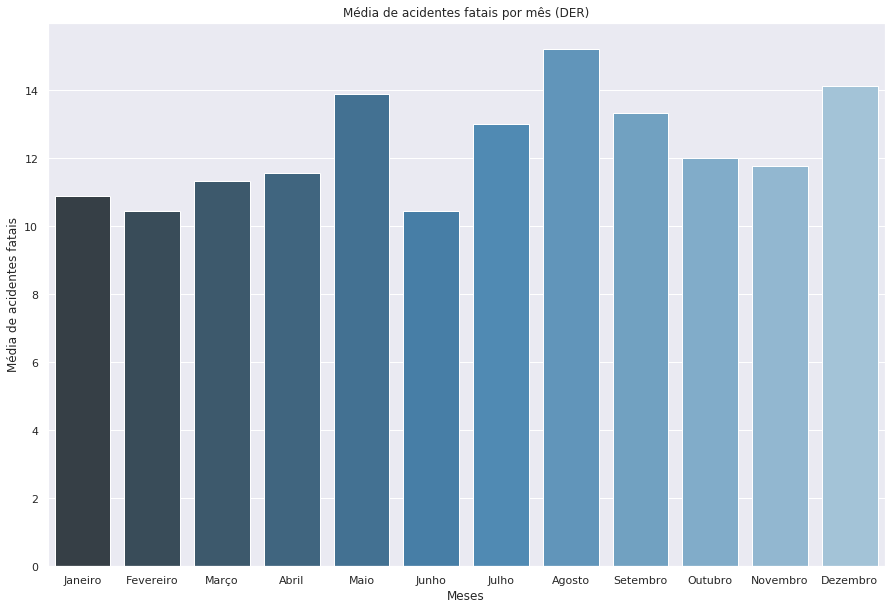

In [17]:
df_acidentes_fatais_2008_2017['Data'] = pd.to_datetime(df_acidentes_fatais_2008_2017['Data'], dayfirst=True)
df_acidentes_fatais_2008_2017['Mes'] = df_acidentes_fatais_2008_2017['Data'].dt.month
media_acidentes_der_meses = df_acidentes_fatais_2008_2017.groupby('Mes').count().reset_index()
media_acidentes_der_meses['Natureza'] = media_acidentes_der_meses['Natureza'] / 9
media_acidentes_der_meses = media_acidentes_der_meses[['Mes', 'Natureza']]
media_acidentes_der_meses['Mes'] = media_acidentes_der_meses['Mes'].replace(dict_meses)
media_acidentes_der_meses

sns.barplot(x = media_acidentes_der_meses['Mes'], y = media_acidentes_der_meses['Natureza'], data = media_acidentes_der_meses, palette = "Blues_d")
plt.title("Média de acidentes fatais por mês (DER)")
plt.xlabel("Meses")
plt.ylabel("Média de acidentes fatais")

In [18]:
medias_acidentes_precipitacao = pd.merge(media_precipitacao_meses, media_acidentes_rodovias_meses, left_on='Mes', right_on='Mes')
medias_acidentes_precipitacao = medias_acidentes_precipitacao.merge(media_acidentes_der_meses, on='Mes')
medias_acidentes_precipitacao = medias_acidentes_precipitacao.rename(columns={"causa_acidente": "Acidentes Rodovias", "Natureza": "Acidentes Fatais (DER)"})
medias_acidentes_precipitacao

,Mes,Precipitacao,Acidentes Rodovias,Acidentes Fatais (DER)
0,Janeiro,8.204516,106.000000,10.888889
1,Fevereiro,7.641489,104.666667,10.444444
2,Março,10.480645,119.888889,11.333333
3,Abril,6.002333,108.444444,11.555556
4,Maio,1.386774,122.555556,13.888889
5,Junho,0.184333,114.333333,10.444444
6,Julho,0.032581,115.333333,13.000000
7,Agosto,0.170874,130.625000,15.222222
8,Setembro,1.196296,108.375000,13.333333
9,Outubro,5.809319,115.125000,12.000000


In [19]:
def correlaciona_acidentes_precipitacao(acidentes):
    corr_acidentes_precipitacao = medias_acidentes_precipitacao[acidentes].corr(medias_acidentes_precipitacao['Precipitacao'])    

    print('Valor da correlação: {}'.format(corr_acidentes_precipitacao))
    sns.regplot(x = medias_acidentes_precipitacao['Precipitacao'], y = medias_acidentes_precipitacao[acidentes], data = medias_acidentes_precipitacao, fit_reg = True)
    plt.title("Correlação entre a média de precipitação e " + acidentes)
    plt.show()

Valor da correlação: -0.3359042769725179


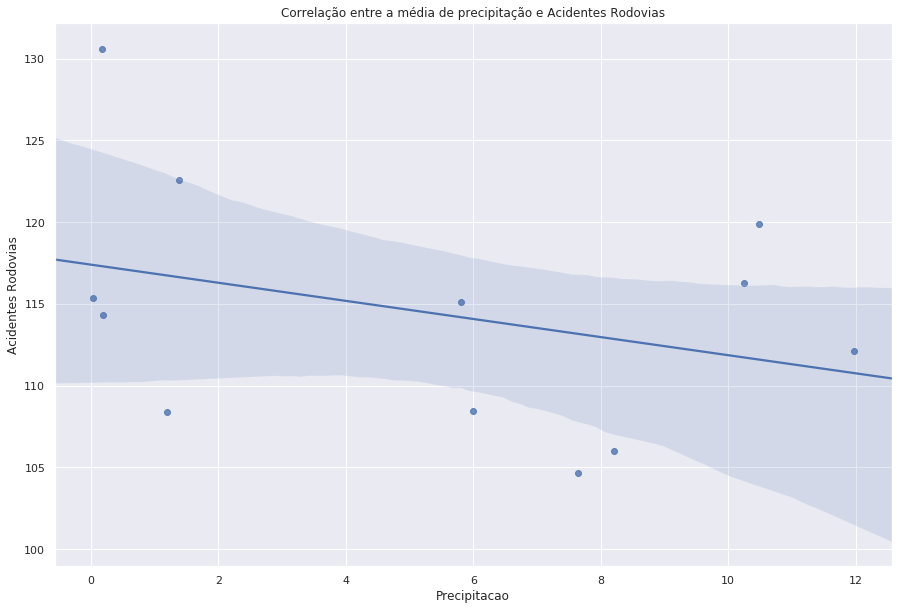

In [20]:
correlaciona_acidentes_precipitacao('Acidentes Rodovias')

Valor da correlação: -0.36704298958002474


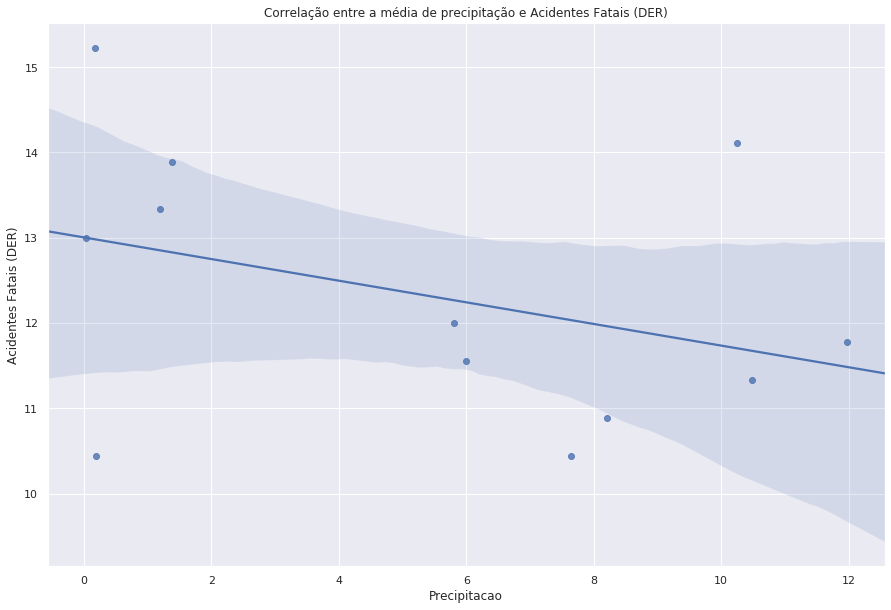

In [21]:
correlaciona_acidentes_precipitacao('Acidentes Fatais (DER)')